### Summary

작성일 : 19/08/22   

<목적>  
변수(ProductCD)의 의미를 파악하고, 이를 바탕으로 Fraud detecting에 도움이 될 feature를 발견하고자 함  

<결론>  
Product == R인 데이터의 경우 다음과 같은 두가지 패턴을 발견  
1) 결제 단위가 25, 50인점  
2) yealy 패턴(연말에 거래가 급증)이 발견  

이를 바탕으로 R은 기프트 카드 결제 데이터라고 추정


<향후 계획>  
도난 카드로 예상되는 데이터를 추출하는 feature 추가할 예정 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc, datetime, time
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_trans = pd.read_csv("/Users/jeong/downloads/IEEE/input/train_transaction.csv")
train_idf = pd.read_csv("/Users/jeong/downloads/IEEE/input/train_identity.csv")

test_trans = pd.read_csv("/Users/jeong/downloads/IEEE/input/test_transaction.csv")
test_idf = pd.read_csv("/Users/jeong/downloads/IEEE/input/test_identity.csv")

train_trans = pd.merge(train_trans, train_idf, on = 'TransactionID', how = 'left')
test_trans = pd.merge(test_trans, test_idf, on = 'TransactionID', how = 'left')

In [3]:
train_trans['day'] = round(train_trans['TransactionDT'] / 60 / 60 / 24, 0)
test_trans['day'] = round(test_trans['TransactionDT'] / 60 / 60 / 24, 0)

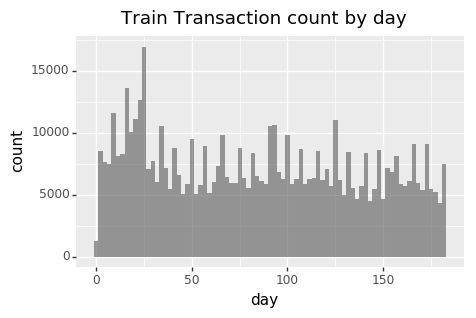

<ggplot: (-9223372029307858123)>


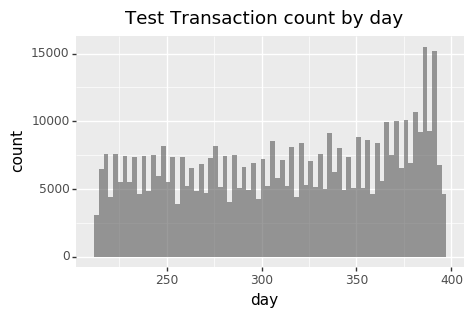

<ggplot: (-9223372029305689621)>


In [4]:
p = ggplot(train_trans, aes(x = 'day')) + geom_histogram(alpha = 0.6) + ggtitle("Train Transaction count by day") + theme(figure_size=(5, 3))
print(p)
p = ggplot(test_trans, aes(x = 'day')) + geom_histogram(alpha = 0.6) + ggtitle("Test Transaction count by day") + theme(figure_size=(5, 3))
print(p)

(참고 : Train/Test Transaction 추이)
Train에서는 0~25일, Test에서는 375~400일 사이에 거래량이 갑자기 늘어나는것을 확인할 수 있습니다.

### 1. 평소 대비 연말 기간의 높은 거래량은 ProductCD 'R, H'항목의 평소 대비 높은 거래량 때문으로 추정¶

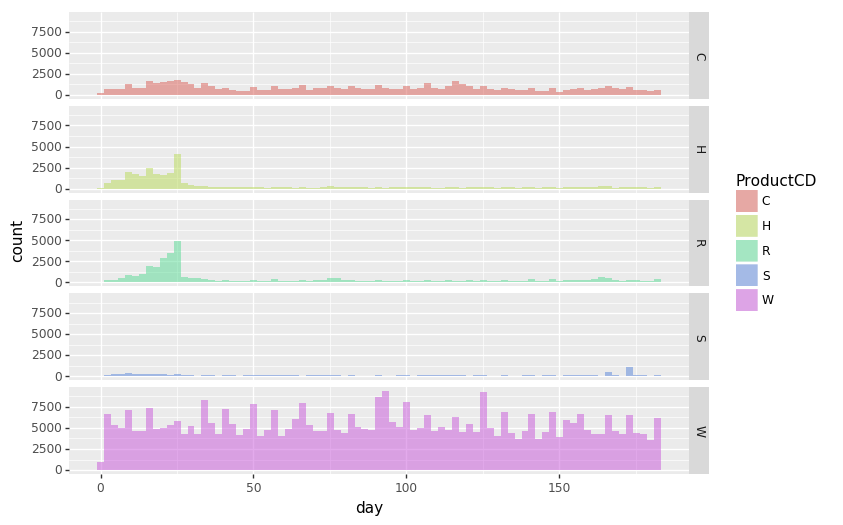

<ggplot: (7545242081)>


In [5]:
p = ggplot(train_trans, aes(x = 'day', fill = 'ProductCD')) + geom_histogram(alpha = 0.5) + theme(figure_size=(8, 6))  + facet_grid("ProductCD~.")
print(p)

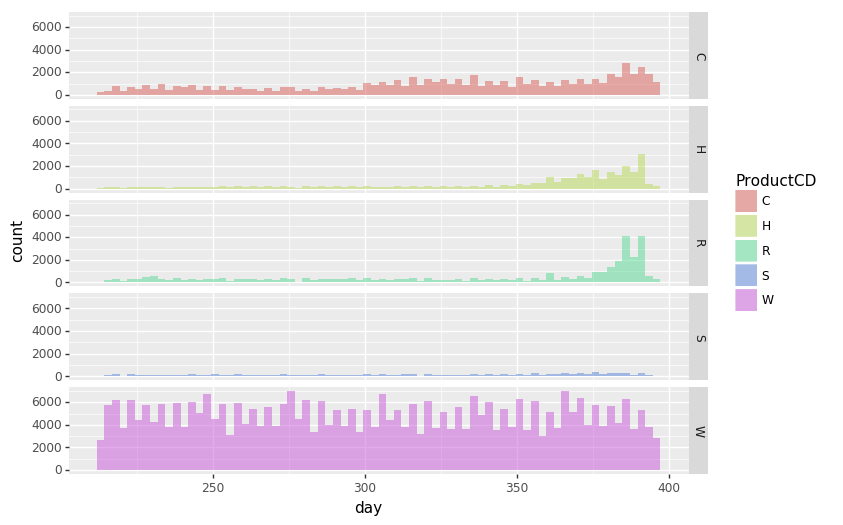

<ggplot: (-9223372029305816092)>


In [6]:
p = ggplot(test_trans, aes(x = 'day', fill = 'ProductCD')) + geom_histogram(alpha = 0.5) + theme(figure_size=(8, 6))  + facet_grid("ProductCD~.")
print(p)

- W는 연중 지속적으로 발생하는 경향. C도 연말 기간 거래량은 상승하지만 상승 폭이 크지는 않아 연말 기간의 급등세를 설명하기에는 부족
- R, H의 해당 기간 급등세가 두드러지며, 연말 기간의 높은 거래량(약 2만건) 중 90% 의 비중을 차지

### 2. 연말 기간 동안 ProductCD의 H, R의 fraud_ratio는 오히려 낮았으며, 이외 기간에는 오히려 높아지는 경향을 보임

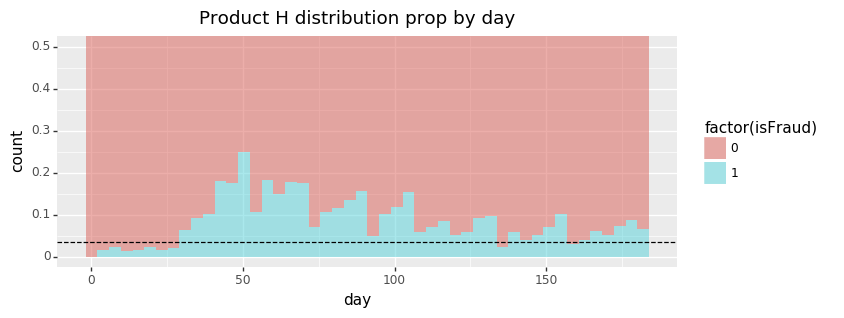

<ggplot: (-9223372029305889974)>


In [7]:
ex = train_trans[train_trans['ProductCD']=='H']
#p = ggplot(ex, aes(x = 'day', fill = 'factor(isFraud)')) + geom_histogram(alpha = 0.5) + ggtitle("Product H distribution by day")  + theme(figure_size=(8, 3))
#print(p)
p = ggplot(ex, aes(x = 'day', fill = 'factor(isFraud)')) + geom_histogram(alpha = 0.5, position = 'fill') + ggtitle("Product H distribution prop by day")  + theme(figure_size=(8, 3)) + coord_cartesian( ylim = (0, 0.5)) + geom_hline(yintercept = 0.035, colour="black", linetype="dashed")
print(p)

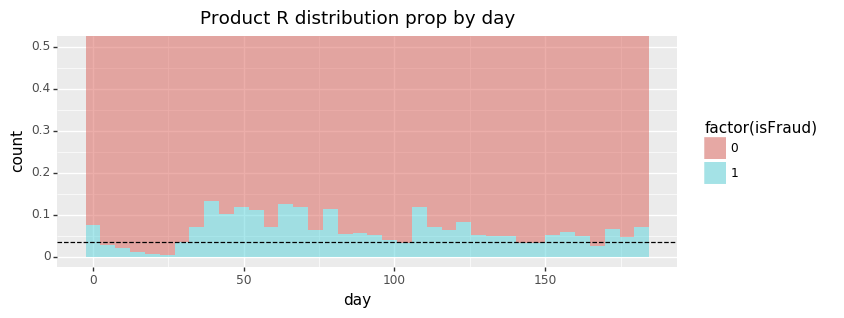

<ggplot: (7548906283)>


In [8]:
ex = train_trans[train_trans['ProductCD']=='R']
#p = ggplot(ex, aes(x = 'day', fill = 'factor(isFraud)')) + geom_histogram(alpha = 0.5) + ggtitle("Product R distribution by day")  + theme(figure_size=(8, 3))
#print(p)
p = ggplot(ex, aes(x = 'day', fill = 'factor(isFraud)')) + geom_histogram(alpha = 0.5, position = 'fill') + ggtitle("Product R distribution prop by day")  + theme(figure_size=(8, 3)) + coord_cartesian( ylim = (0, 0.5)) + geom_hline(yintercept = 0.035, colour="black", linetype="dashed")
print(p)

In [9]:
train_trans['day_0_25_YN'] = 'Y'
train_trans.loc[train_trans['day'] > 25, 'day_0_25_YN'] = 'N'

In [10]:
ex = train_trans[ (train_trans['ProductCD']== 'R') | (train_trans['ProductCD']== 'H')]
ex = ex.groupby(['ProductCD','day_0_25_YN']).agg({'isFraud':['count','mean']}).reset_index()
ex.columns = ['ProductCD','day_0_25_YN', 'count', 'mean' ]
ex

,ProductCD,day_0_25_YN,count,mean
0,H,N,14600,0.085753
1,H,Y,18424,0.017477
2,R,N,20267,0.062515
3,R,Y,17432,0.009121


- H, R의 0~25일의 fraud_ratio는 전체 평균인 3.5% 보다 현저하게 낮은 경향을 보임.
- 또한, 25일 전후 여부에 따라 fraud_ratio가 극명하게 차이가 나는데(위의 표 참조), H,R과 25일 전후 여부를 combination feature 생성하는건? (feat1)

### 3. 상품 R은 1) 결제 금액의 단위가 일정한 점(ex. 50, 100, 150...), 2) 연말에 거래가 폭증하는 점으로 볼때, 기프트 카드 구매 금액으로 추정

In [13]:
ex_R = train_trans[train_trans['ProductCD']=='R']
print(ex_R.TransactionAmt.value_counts().nlargest(10))
print(ex_R.TransactionAmt.max())

100.0    11836
150.0     5655
200.0     5137
50.0      3515
250.0     2662
75.0      1791
125.0     1766
300.0     1481
500.0      739
25.0       568
Name: TransactionAmt, dtype: int64
1800.0


- 상품 R의 TransactionAmt를 보면, 단위가 25, 50씩 증가
- 연말 기간 미국 기프트카드 사용자가 급증한다는 점으로 볼때 상품 R은 기프트카드 상품이라고 추정해 볼 수 있음  
참고 1) 미국 기프트 카드 소개 ( http://www.koreatimes.com/article/20161220/1030170)

### 4. 가설) 상품 R이 단기간 내(1시간, 1일) 같은 금액으로 반복 결제된 경우, 도난된 신용 카드로 기프트카드를 반복 구매하는것으로 추정해 볼 수 있음

In [15]:
ex_R.sort_values('V95', ascending = False, inplace = True)
ex_R.loc[ex_R['day']==52,['isFraud','V95','V126','TransactionAmt','day','card1']].head(10)

,isFraud,V95,V126,TransactionAmt,day,card1
198780,1,12.0,2400.0,200.0,52.0,1675
198778,1,11.0,2200.0,200.0,52.0,1675
198776,1,10.0,2000.0,200.0,52.0,1675
198773,1,9.0,1800.0,200.0,52.0,1675
198772,1,8.0,1600.0,200.0,52.0,1675
198771,1,7.0,1400.0,200.0,52.0,1675
198769,1,6.0,1200.0,200.0,52.0,1675
198768,1,5.0,1000.0,200.0,52.0,1675
197903,0,4.0,200.0,50.0,52.0,17458
198766,1,4.0,800.0,200.0,52.0,1675


- 52일의 경우, 도난된 신용카드로 200씩 12번에 걸쳐서 거래를 진행했고, 이 경우 모두 Fraud==1을 나타냈다.
- (feat2) day, card1별로 value_count를 나타내되, 연말 기간(0~25일)은 NA값으로 대치한다. -> 도난당해 결제된 기프트 카드 발굴 feature